# Лабораторная работа 2. Решающие деревья и случайные леса.

ФИО: Мерцалов А. Д.

Группа: 317

In [1]:
import numpy as np

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingClassifier, RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import train_test_split
from copy import deepcopy
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, accuracy_score
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder
EPS = 1e-5
IS_CATEGORY = 0
IS_FLOAT = 1
INF = 1e9

/Users/skrrydg/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### I. Решающие деревья своими руками
#### Задача 1.
В этой части вам нужно реализовать свой класс для обучения решающего дерева в задаче бинарной классификации с возможностью обработки вещественных и категориальных признаков.

__1__

Реализуйте следующую функцию:

In [4]:
def get_cumsum(y, pref):
    if (pref):
        return (np.cumsum(np.asarray(y == 1, dtype=int)), np.cumsum(np.asarray(y == 0, dtype=int)))
    else:
        return (np.cumsum(np.asarray(y[::-1] == 1, dtype=int))[::-1], 
                np.cumsum(np.asarray(y[::-1] == 0, dtype=int))[::-1])

def find_best_split(feature_vector, target_vector, visualize = 0):
    x = deepcopy(feature_vector)
    y = deepcopy(target_vector)
    x = x.reshape(-1)
    y = y.reshape(-1)
    assert(x.shape == y.shape)
    if (np.unique(feature_vector).shape[0] == 1):
        return (None, None, -INF, None)
    
    sort_ind = np.argsort(x)

    x = x[sort_ind]
    y = y[sort_ind]
    
    ind = np.where(x != x[0])[0][0]
    
    sum_1_pref, sum_0_pref = get_cumsum(y, 1)
    sum_1_suf, sum_0_suf = get_cumsum(y, 0)
    
    cnt_pref = np.cumsum(np.ones(x.shape[0]))
    cnt_suf = cnt_pref[::-1]
    
    thresholds = x[ind:]
    sum_1_pref = np.asarray(sum_1_pref[:-ind], dtype=float)
    sum_0_pref = np.asarray(sum_0_pref[:-ind], dtype=float)
    cnt_pref = cnt_pref[:-ind]
    
    sum_1_suf = np.asarray(sum_1_suf[ind:], dtype=float)
    sum_0_suf = np.asarray(sum_0_suf[ind:], dtype=float)
    cnt_suf = cnt_suf[ind:]
    
    if (visualize):
        print(sum_1_pref)
        print(sum_0_pref)

        print(sum_1_suf)
        print(sum_0_suf)
    
    ginis = cnt_pref * (1 - (sum_1_pref / cnt_pref) ** 2 - (sum_0_pref / cnt_pref) ** 2) + \
            cnt_suf * (1 - (sum_1_suf / cnt_suf) ** 2 - (sum_0_suf / cnt_suf) ** 2)
    ginis *= - 1. / x.shape[0]
    
    if (visualize):
        print(thresholds)
        print(ginis)
    
    thresholds, ind_unique = np.unique(thresholds, return_index=1) # Удаляем все повторяющиеся элементы
    return (thresholds, ginis[ind_unique], np.max(ginis[ind_unique]), thresholds[np.argmax(ginis[ind_unique])])

Параметры:
* feature_vector: вещественнозначный вектор значений признака (np.array)
* target_vector: вектор классов объектов (np.array). len(feature_vector)==len(target_vector).

Возвращаемые значения:
* thresholds: отсортированный по возрастанию вектор со всеми возможными порогами, по которым объекты можно разделить на две различные подвыборки, или поддерева (np.array)
* ginis: вектор со значениями критерия Джини для каждого из порогов в thresholds. (np.array, len(ginis)==len(thresholds))
* оптимальный порог (число)
* оптимальное значение критерия Джини (число)

Под критерием Джини здесь подразумевается следующая функция:
$$Q(R) = -\frac {|R_l|}{|R|}H(R_l) -\frac {|R_r|}{|R|}H(R_r),$$
$R$ - множество объектов, $R_l$ и $R_r$ - объекты, попавшие в левое и правое поддерево, $H(R) = 1-p_1^2-p_0^2$, $p_1$, $p_0$ - доля объектов класса 1 и 0 соответственно.

Указания:
* Пороги, приводящие к попаданию в одно из поддеревьев пустого множества объектов, не рассматриваются.
* За наличие в функции циклов балл будет снижен. Векторизуйте! :)

In [5]:
## Only for testing
x = np.array((0, 0, 0, 0, 1, 2, 3), dtype=float)
y = np.array((0, 1, 1, 0, 1, 0, 1), dtype=float)
(thresholds, ginis, best_g, best_t) = find_best_split(x, y)
print(thresholds)
print(ginis)
print(best_g)
print(best_t)

[ 1.  2.  3.]
[-0.19047619 -0.28571429 -0.19047619]
-0.190476190476
1.0


__2__
Загрузите таблицу [students.csv](https://drive.google.com/file/d/0B2zoFVYw1rN3a0d0Zm43TzQ4aUU/view?usp=sharing) (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах,а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог - значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте scatter-графики "значение признака - класс" для всех пяти признаков.

In [6]:
students = pd.read_csv("./students.csv")
X = np.asarray(students.iloc[:, :-1])
y = np.asarray(students.ix[:, -1:])

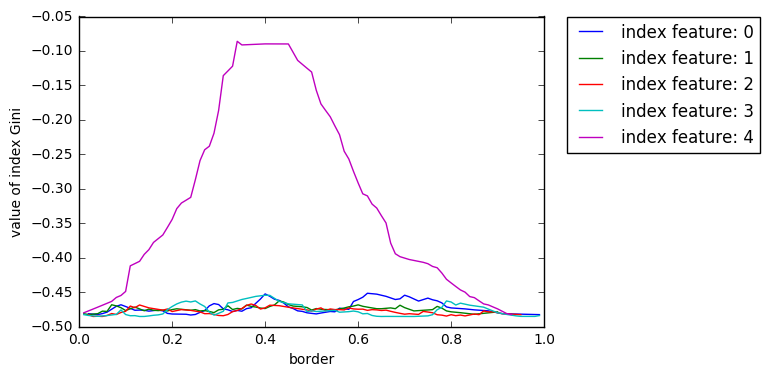

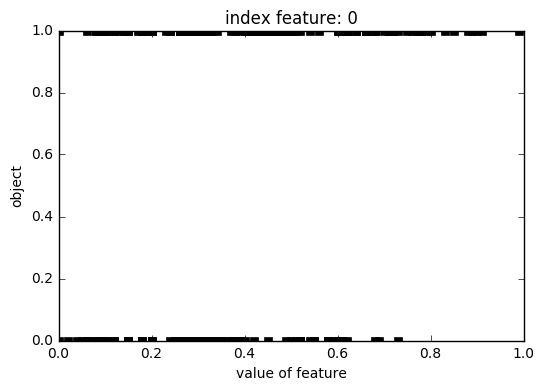

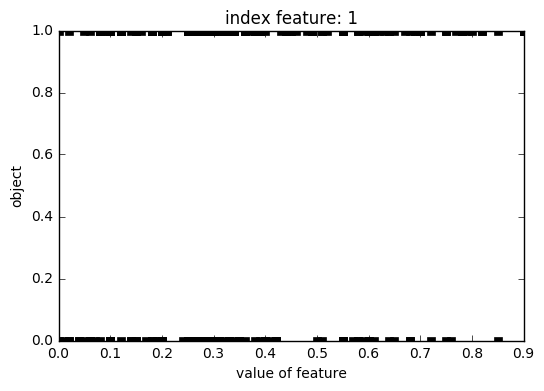

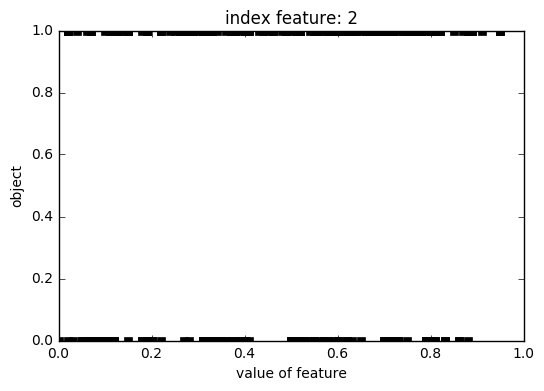

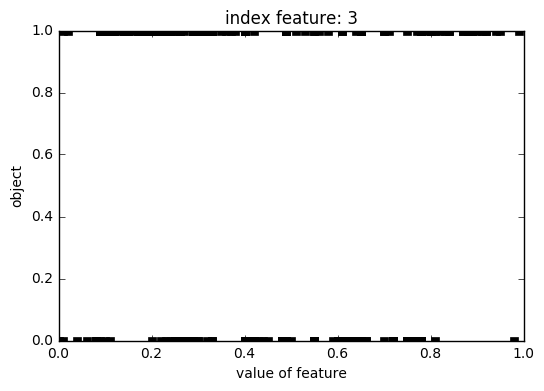

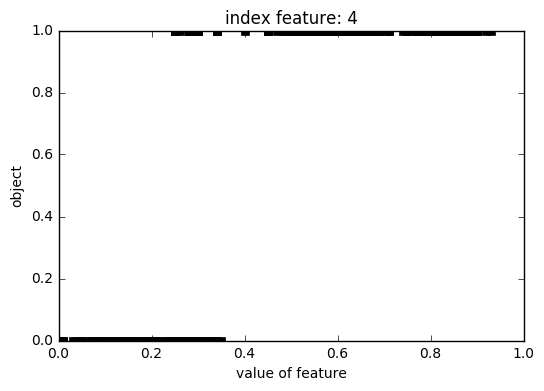

In [7]:
line = [0 for i in range(X.shape[1])]
for i in range(X.shape[1]):
    (thresholds, ginis, a, b) = find_best_split(X[:, i], y)
    line[i], = plt.plot(thresholds, ginis)
    
plt.xlabel("border")
plt.ylabel("value of index Gini")
plt.legend(line, ["index feature: " + str(i) for i in range(X.shape[1])], 
               bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()


for i in range(X.shape[1]):
    line[i], = plt.plot(X[:, i], y, 'ks')
    
    plt.xlabel("value of feature")
    plt.ylabel("object")
    plt.title('index feature: ' + str(i))
    plt.show()



__3__

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой scatter-графиков? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

По четвертому.

Согласуется, объекты с y == 0 находятся левее, чем объекты с y == 1

Кривая должна быть как можно ближе к той что привидена на следующей картинке (для хорошего разделения)

<img src="image/goodGini.png">


Кривая должна быть как можно ближе к той что привидена на следующей картинке (для плохого разделения)

<img src="image/badGini.png">

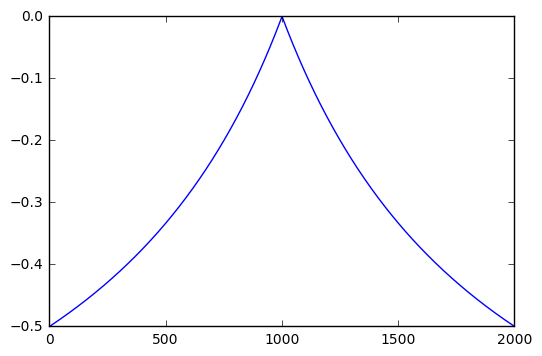

In [26]:
# Create goodGini
(thresholds, ginis, a, b) = \
    find_best_split( \
            np.cumsum(np.ones(2000)), \
            np.concatenate((np.zeros(1000), np.ones(1000)), axis = 0) \
        )
plt.plot(thresholds, ginis)

__4__

Реализуйте класс для обучения решающих деревьев. Мы не будем усложнять класс множеством параметров, как в sklearn. Требования к классу:
* Единственный параметр дерева - вектор, задающий типы признаков: если в позиции i стоит 0, то с признаком номер i нужно работать как с вещественным, если 1 - как с категориальным.
* Чтобы классификатор "распознавался" функциями sklearn, необходимо наследовать его от BaseEstimator. 
* У класса должно быть реализовано два метода: fit и predict. Метод fit принимает на вход двумерный np.array - матрицу объекты-признаки и одномерный вектор ответов y, внутри метода происходит обучение дерева. Метод predict принимает на вход двумерную матрицу объекты-признаки (np.array) и возвращает вектор предсказанных классов (одномерный np.array) для всех объектов.
* Построение дерева должно осуществляться согласно базовому жадному алгоритму. Выбор лучшего разбиения необходимо производить по критерию Джини. Критерий останова: все объекты в листе относятся к одному классу. Ответ в листе: класс объектов, находящихся в нем. Для категориальных признаков необходимо выполнить преобразование, описанное на [семинаре](https://github.com/esokolov/ml-course-msu/blob/master/ML16/lecture-notes/Sem04_trees.pdf) в разделе "Учет категориальных признаков".

Далее будут даны рекомендации по реализации решающего дерева. Им следовать необязательно: например, вы можете использовать свою структуру для хранения дерева.
* Дерево можно хранить в виде сложенных списков. Каждая внутренняя вершина дерева - список node длины 4: node[0] хранит индекс признака, по которому в данной вершине делается разбиение, node[1] - порог для разбиения, если i-й признак вещественный, и множество значений признака, с которыми объект попадает в левое поддерево, если i-й признак категориальный, node[2] - левое поддерево (список) и node[3] - правое поддерево (список). В листьях node состоит из единственного элемента - ответа, возвращаемого в этом листе. Пример простого дерева, разделяющего выборку по нулевому признаку по порогу 5 на два листа, возвращающих класс 0 и 1: [0, 5, [0], [1]]. Если в левом поддереве корня выполнять разделение по 1-му признаку по порогу 7: [0, 5, [1, 7, [0], [1]], [1]].
* Внутри функции fit определяется рекурсивная функция fit_node(subX, suby, node), принимающая матрицу объекты-признаки subX и ответы на этих объектах suby, а также ссылку на пустой список node - вершину, в которой необходимо выполнить разбиение на две подвыборки. Функция fit_node должна заполнить этот список вызовами node.append(.....). Если suby состоит из одинаковых значений, нужно добавить к node это значение и выйти. Иначе выполнить перебор по всем признакам: для каждого признака с помощью функции find_best_split найти наилучшее разбиение и выбрать признак, дающий максимальное значение критерия Джини. Для категориальных признаков нужно выполнить специальное преобразование (см. семинар). Вершину нужно заполнить индексом выбранного признака, порогом или множеством значений (задающих разбиение), а затем рекурсивно вызвать fit_node для левого и правого поддерева.
* Внутри функции predict также определяется рекурсивная функция predict_node(x, node), принимающая один объект и вершину. Она проверяет, является ли node листом (это можно определить по длине списка), если да - возвращает node[0], т. е. класс, задаваемый этим листом. Иначе функция определяет, к какому поддереву относится объект, и рекурсивно вызывает себя для этого поддерева.
* В процессе тестирования кода может оказаться, что рекурсивные вызовы повторяются бесконечно. Так происходит, если в одно из поддеревьев попадает пустая подвыборка. Этого быть не должно: пороги, при которых все объекты попадают в одно поддерево, не рассматриваются (см. указания к функции find_best_split).
* Дерево должно давать единичную долю верных ответов на обучающей выборке.
* Протестировать, правильно ли выполняется преобразование категориальных признаков, можно на простой синтетической выборке с одним категориальным признаком, по которому объекты идеально делятся на два класса, и при этом такого эффекта нельзя достичь установкой порога на этот признак.

In [8]:
from sklearn.base import BaseEstimator

In [9]:
def find_best_split_for_category(feature_vector, target_vector, visualize = 0):
    x = deepcopy(feature_vector)
    y = deepcopy(target_vector)
    x = x.reshape(-1)
    y = y.reshape(-1)
    assert(x.shape == y.shape)
    if (np.unique(feature_vector).shape[0] == 1):
        return (None, None, -INF, None)
    

    
    ind_sort = np.argsort(x)
    x = x[ind_sort]
    y = y[ind_sort]
    
    cnt = 0
    cnt_pos = 0
    match_cat_cnt = {}
    match_cat_cnt_pos = {}
    for i in range(x.shape[0]):
        cnt += 1
        cnt_pos += (y[i] == 1)
        if (i == x.shape[0] - 1) or (x[i] != x[i + 1]):
            match_cat_cnt.update({x[i]: cnt})
            match_cat_cnt_pos.update({x[i]: cnt_pos})
            cnt = 0
            cnt_pos = 0
    
    cnt_per_category = np.ndarray(x.shape[0])
    cnt_pos_per_category = np.ndarray(x.shape[0])
    for i in range(x.shape[0]):
        cnt_pos_per_category[i] = match_cat_cnt_pos[x[i]]
        cnt_per_category[i] = match_cat_cnt[x[i]]
        
    if (visualize):
        print("cnt_per_category:", cnt_per_category)
        print("cnt_pos_per_category:", cnt_pos_per_category)
        print("x:", x)
        print("y:", y)
    
    sort_ind = np.argsort(cnt_per_category / cnt_pos_per_category)
        
    x = x[sort_ind]
    y = y[sort_ind]
    
    if (visualize):
        print("sort_x", x)
        print("sort_y", y)
    
    sum_1_pref, sum_0_pref = get_cumsum(y, 1)
    sum_1_suf, sum_0_suf = get_cumsum(y, 0)
    
    cnt_pref = np.cumsum(np.ones(x.shape[0]))
    cnt_suf = cnt_pref[::-1]
    
    thresholds = x[1:]
    sum_1_pref = np.asarray(sum_1_pref[:-1], dtype=float)
    sum_0_pref = np.asarray(sum_0_pref[:-1], dtype=float)
    cnt_pref = cnt_pref[:-1]
    
    sum_1_suf = np.asarray(sum_1_suf[1:], dtype=float)
    sum_0_suf = np.asarray(sum_0_suf[1:], dtype=float)
    cnt_suf = cnt_suf[1:]
    
    if (visualize):
        print("sum_1_pref:", sum_1_pref)
        print("sum_0_pref:", sum_0_pref)

        print("sum_1_suf:", sum_1_suf)
        print("sum_0_suf:", sum_0_suf)
    
    ginis = cnt_pref * (1 - (sum_1_pref / cnt_pref) ** 2 - (sum_0_pref / cnt_pref) ** 2) + \
            cnt_suf * (1 - (sum_1_suf / cnt_suf) ** 2 - (sum_0_suf / cnt_suf) ** 2)
    ginis *= - 1. / x.shape[0]
    
    if (visualize):
        print("thresholds:", thresholds)
        print("ginis:", ginis)
    
        
    unique_thresholds, ind_unique = np.unique(thresholds, return_index=1) # Удаляем все повторяющиеся элементы
    
    best_g = np.max(ginis[ind_unique])
    best_t = unique_thresholds[np.argmax(ginis[ind_unique])]
    set_cat = {}
    for i in range(np.sort(np.where(ginis == best_g)[0])[0] + 1):
        set_cat.update({x[i]: 1})
    
    assert(unique_thresholds.shape[0] + 1 != len(set_cat))
    return (unique_thresholds, ginis[ind_unique], best_g, set_cat)

In [10]:
## Only for testing
x = np.array((0, 0, 1, 1, 2, 2), dtype=float)
y = np.array((0, 0, 1, 1, 0, 0), dtype=float)
(thresholds, ginis, best_g, best_t) = find_best_split_for_category(x, y, 0)
print(thresholds)
print(ginis)
print(best_g)
print(best_t)

[ 0.  1.  2.]
[-0.         -0.26666667 -0.33333333]
-0.0
{1.0: 1}


In [11]:
### Шаблон класса, следующего рекомендациям
class DecisionTree(BaseEstimator):
    def __init__(self, types):
        self._tree = []
        self.types = types

    def fit(self, X, y, visual = 0):
        
        def fit_node(subX, suby, node, visual = 0):
            if (visual):
                print("Begin fit node")
            if (np.unique(suby).shape[0] == 1):
                node.append(suby[0])
                if (visual):
                    print("Leaf")
                return
            
            ma = -INF
            ind_ma = -1
            t_ma = -1
            for i in range(subX.shape[1]):
                if (self.types[i] == IS_FLOAT):
                    (thresholds, ginis, best_g, best_t) = find_best_split(subX[:, i], suby)
                else: 
                    (thresholds, ginis, best_g, best_t) = find_best_split_for_category(subX[:, i], suby)
                if (ma < best_g):
                    ma = best_g
                    ind_ma = i
                    t_ma = best_t
            assert(ind_ma != -1)
            assert(t_ma != -1)
            
            node.append(ind_ma)
            node.append(t_ma)
            node.append([])
            node.append([])
            if (self.types[ind_ma] == IS_FLOAT):
                ind_l = subX[:, ind_ma] < (t_ma - EPS)
                ind_r = subX[:, ind_ma] >= (t_ma - EPS)
            else:
                ind_l = np.zeros(subX.shape[0])
                ind_r = np.zeros(subX.shape[0])
                for i in range(subX.shape[0]):
                    if (t_ma.get(subX[i, ind_ma]) is None):
                        ind_r[i] = 1
                    else:
                        ind_l[i] = 1
                
            assert(np.count_nonzero(ind_l) != 0)
            assert(np.count_nonzero(ind_r) != 0)
            assert(np.count_nonzero(ind_l) + np.count_nonzero(ind_r) == subX.shape[0])
            
            ind_l = np.asarray(ind_l, dtype=bool)
            ind_r = np.asarray(ind_r, dtype=bool)
            if (visual):
                print("ind_l:", ind_l)
                print("ind_r:", ind_r)
                print("suby[ind_l]:", suby[ind_l])
                print("suby[ind_r]:", suby[ind_r])
            
            fit_node(subX[ind_l],  
                     suby[ind_l],
                     node[2], 
                     visual)
            fit_node(subX[ind_r],  
                     suby[ind_r],
                     node[3], 
                     visual)
        fit_node(X, y.reshape(-1), self._tree, visual)
        
    def predict(self, X):
        def predict_node(x, node):
            if (len(node) == 1):
                return node[0]
            else:
                ind = node[0]
                if (self.types[ind] == IS_CATEGORY):
                    set_cat = node[1]
                    if (set_cat.get(x[ind]) is None):
                        return predict_node(x, node[3])
                    else:
                        return predict_node(x, node[2])
                else:
                    border = node[1]
                    if (x[ind] < border - EPS):
                        return predict_node(x, node[2])
                    else:
                        return predict_node(x, node[3])
            
        predicted = []
        for x in X:
            predicted.append(predict_node(x, self._tree))
        return np.array(predicted)

__5__

Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). Вам нужно скачать таблицу agaricus-lepiota.data (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/)), прочитать ее с помощью pandas, применить к каждому столбцу LabelEncoder (из sklearn), чтобы преобразовать строковые имена категорий в натуральные числа. Первый столбец - это целевая переменная (e-edible, p-poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что - классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

У вас должно получиться значение accuracy, равное единице (или очень близкое к единице), и не очень глубокое дерево.

In [12]:
#transform
for i in range(10):
    mushrooms = pd.read_csv("./mushrooms.csv")
    mushrooms = np.asarray(mushrooms.iloc[:])
    le = LabelEncoder()
    for i in range(mushrooms.shape[1]):
        le.fit(mushrooms[:, i])
        mushrooms[:, i] = le.transform(mushrooms[:, i])


    y = mushrooms[:, 0:1].reshape(-1)
    X = mushrooms[:, 1:]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5)
    #predict
    dt = DecisionTree(np.zeros(X.shape[1]))
    dt.fit(X_train, y_train, 0)
    print(np.count_nonzero(dt.predict(X_test) == y_test) / y_test.shape[0])

1.0
0.999015263417036
1.0
1.0
1.0
1.0
1.0
1.0
0.999015263417036
0.9985228951255539


__6__

Загрузите следующие наборы данных (напомним, что pandas умеет загружать файлы по url, в нашем случае это файл \*.data), предварительно ознакомившись с описанием признаков и целевой переменной в каждом из них (она записаны в Data Folder, в файле *.names): 
* [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom) (загрузили в предыдущем пункте, классы записаны в нулевом столбце),
* [tic-rac-toe](https://archive.ics.uci.edu/ml/datasets/Tic-Tac-Toe+Endgame) (классы записаны в последнем столбце)
* [cars](https://archive.ics.uci.edu/ml/datasets/Car+Evaluation) (классы записаны в последнем столбце, считаем что unacc, acc - это класс 0, good, vgood - класс 1)
* [nurcery](https://archive.ics.uci.edu/ml/datasets/Nursery) (классы записаны в последнем столбце, считаем, что not_recom и recom - класс 0, very_recom, priority, spec_prior - класс 1).

Закодируйте категориальные признаки, использовав LabelEncoder. С помощью cross_val_score (cv=10) оцените accuracy на каждом из этих наборов данных следующих алгоритмов:
* DecisionTree, считающий все признаки вещественными
* DecisionTree, считающий все признаки категориальными
* DecisionTree, считающий все признаки вещественными + one-hot-encoding всех признаков
* DecisionTreeClassifier из sklearn. Запишите результат в pd.DataFrame (по строкам - наборы данных, по столбцам - алгоритмы).

Рекомендации:
* Чтобы cross_val_score вычисляла точность, нужно передать scorer=make_scorer(accuracy_score), обе фукнции из sklearn.metrics.
* Если вам позволяет память (а она скорее всего позволяет), указывайте параметр sparse=False в OneHotEncoder (если вы, конечно, используете его). Иначе вам придется добиваться того, чтобы ваша реализация дерева умела работать с разреженными матрицами (что тоже, в целом, не очень сложно).

In [148]:
result_table = pd.DataFrame(data = np.ndarray((4, 4)), 
                            index = ["mushrooms", "tic-tac-toe", "cars", "nurcery"],
                            columns=["all_category", "all_float", "all_float + one-hot-encoding", "sklearn"])

In [149]:
mushrooms = pd.read_csv("./mushrooms.csv")
mushrooms = np.asarray(mushrooms.iloc[:])
le = LabelEncoder()
for i in range(mushrooms.shape[1]):
    le.fit(mushrooms[:, i])
    mushrooms[:, i] = le.transform(mushrooms[:, i])


y = np.asarray(mushrooms[:, 0:1].reshape(-1), dtype=int)
X = np.asarray(mushrooms[:, 1:], dtype=float)

ind = np.arange(X.shape[0])
np.random.shuffle(ind)
X = X[ind]
y = y[ind]

dt = DecisionTree(np.zeros(X.shape[1])) # Считаем что все признаки катигориальные
arr = cross_val_score(dt, X, y, cv = 10, scoring=make_scorer(accuracy_score))
result_table.loc["mushrooms", "all_category"] = np.mean(arr)

dt = DecisionTree(np.ones(X.shape[1])) # Считаем что все признаки вещественные
arr = cross_val_score(dt, X, y, cv = 10, scoring=make_scorer(accuracy_score))
result_table.loc["mushrooms", "all_float"] = np.mean(arr)

enc = OneHotEncoder(sparse=False)
enc.fit(mushrooms)
mushrooms = enc.transform(mushrooms)
dt = DecisionTree(np.ones(X.shape[1])) # Считаем что все признаки вещественные + oneHotEncoding
arr = cross_val_score(dt, X, y, cv = 10, scoring=make_scorer(accuracy_score))
result_table.loc["mushrooms", "all_float + one-hot-encoding"] = np.mean(arr)

dt = DecisionTreeClassifier() # Из скайлерна
arr = cross_val_score(dt, X, y, cv = 10, scoring=make_scorer(accuracy_score))
result_table.loc["mushrooms", "sklearn"] = np.mean(arr)

In [150]:
tic_rac_toe = pd.read_csv("./tic-tac-toe.csv")
tic_rac_toe = np.asarray(tic_rac_toe.iloc[:])

le = LabelEncoder()
for i in range(tic_rac_toe.shape[1]):
    le.fit(tic_rac_toe[:, i])
    tic_rac_toe[:, i] = le.transform(tic_rac_toe[:, i])


y = np.asarray(tic_rac_toe[:, -1:].reshape(-1), dtype=int)
X = np.asarray(tic_rac_toe[:, :-1], dtype=float)

ind = np.arange(X.shape[0])
np.random.shuffle(ind)
X = X[ind]
y = y[ind]

dt = DecisionTree(np.zeros(X.shape[1])) # Считаем что все признаки катигориальные
arr = cross_val_score(dt, X, y, cv = 10, scoring=make_scorer(accuracy_score))
result_table.loc["tic-tac-toe", "all_category"] = np.mean(arr)

dt = DecisionTree(np.ones(X.shape[1])) # Считаем что все признаки вещественные
arr = cross_val_score(dt, X, y, cv = 10, scoring=make_scorer(accuracy_score))
result_table.loc["tic-tac-toe", "all_float"] = np.mean(arr)


enc = OneHotEncoder(sparse=False)
enc.fit(mushrooms)
mushrooms = enc.transform(mushrooms)
dt = DecisionTree(np.ones(X.shape[1])) # Считаем что все признаки вещественные + oneHotEncoding
arr = cross_val_score(dt, X, y, cv = 10, scoring=make_scorer(accuracy_score))
result_table.loc["tic-tac-toe", "all_float + one-hot-encoding"] = np.mean(arr)

dt = DecisionTreeClassifier() # Из скайлерна
arr = cross_val_score(dt, X, y, cv = 10, scoring=make_scorer(accuracy_score))
result_table.loc["tic-tac-toe", "sklearn"] = np.mean(arr)


In [151]:
cars = pd.read_csv("./cars.csv")
cars = np.asarray(cars.iloc[:])

le = LabelEncoder()
for i in range(cars.shape[1]):
    le.fit(cars[:, i])
    cars[:, i] = le.transform(cars[:, i])


y = np.asarray(cars[:, -1:].reshape(-1), dtype=int)
X = np.asarray(cars[:, :-1], dtype=float)

ind = np.arange(X.shape[0])
np.random.shuffle(ind)
X = X[ind]
y = y[ind]

dt = DecisionTree(np.zeros(X.shape[1])) # Считаем что все признаки катигориальные
arr = cross_val_score(dt, X, y, cv = 10, scoring=make_scorer(accuracy_score))
result_table.loc["cars", "all_category"] = np.mean(arr)

dt = DecisionTree(np.ones(X.shape[1])) # Считаем что все признаки вещественные
arr = cross_val_score(dt, X, y, cv = 10, scoring=make_scorer(accuracy_score))
result_table.loc["cars", "all_float"] = np.mean(arr)


enc = OneHotEncoder(sparse=False)
enc.fit(mushrooms)
mushrooms = enc.transform(mushrooms)
dt = DecisionTree(np.ones(X.shape[1])) # Считаем что все признаки вещественные + oneHotEncoding
arr = cross_val_score(dt, X, y, cv = 10, scoring=make_scorer(accuracy_score))
result_table.loc["cars", "all_float + one-hot-encoding"] = np.mean(arr)

dt = DecisionTreeClassifier() # Из скайлерна
arr = cross_val_score(dt, X, y, cv = 10, scoring=make_scorer(accuracy_score))
result_table.loc["cars", "sklearn"] = np.mean(arr)

In [152]:
nurcery = pd.read_csv("./nurcery.csv")
nurcery = np.asarray(nurcery.iloc[:])

le = LabelEncoder()
for i in range(nurcery.shape[1]):
    le.fit(nurcery[:, i])
    nurcery[:, i] = le.transform(nurcery[:, i])


y = np.asarray(nurcery[:, -1:].reshape(-1), dtype=int)
X = np.asarray(nurcery[:, :-1], dtype=float)

ind = np.arange(X.shape[0])
np.random.shuffle(ind)
X = X[ind]
y = y[ind]

dt = DecisionTree(np.zeros(X.shape[1])) # Считаем что все признаки катигориальные
arr = cross_val_score(dt, X, y, cv = 10, scoring=make_scorer(accuracy_score))
result_table.loc["nurcery", "all_category"] = np.mean(arr)

dt = DecisionTree(np.ones(X.shape[1])) # Считаем что все признаки вещественные
arr = cross_val_score(dt, X, y, cv = 10, scoring=make_scorer(accuracy_score))
result_table.loc["nurcery", "all_float"] = np.mean(arr)


enc = OneHotEncoder(sparse=False)
enc.fit(nurcery)
nurcery = enc.transform(nurcery)
dt = DecisionTree(np.ones(X.shape[1])) # Считаем что все признаки вещественные + oneHotEncoding
arr = cross_val_score(dt, X, y, cv = 10, scoring=make_scorer(accuracy_score))
result_table.loc["nurcery", "all_float + one-hot-encoding"] = np.mean(arr)

dt = DecisionTreeClassifier() # Из скайлерна
arr = cross_val_score(dt, X, y, cv = 10, scoring=make_scorer(accuracy_score))
result_table.loc["nurcery", "sklearn"] = np.mean(arr)

In [153]:
print(result_table)

             all_category  all_float  all_float + one-hot-encoding   sklearn
mushrooms        1.000000   1.000000                      1.000000  1.000000
tic-tac-toe      0.947719   0.834945                      0.834945  0.889108
cars             0.987266   0.917217                      0.917217  0.989004
nurcery          0.999691   0.999846                      0.999846  0.999768


__7__

Проанализируйте результаты эксперимента. 
Одинаково ли для разных наборов данных ранжируются алгоритмы? 
Порассуждайте, почему так происходит. 

Обратите внимание на значение признаков в разных наборах данных. 
Присутствует ли в результатах какая-то компонента случайности? 
Можно ли повлиять на нее и улушить работу алгоритмов?

На данных mushrooms - все дали максимальную точность.

На данных tic-tac-toe - лучше работает all_category

На данных cars - лучше работает sklearn

На данных nurcery - лучше работает all_float и all_float + one-hot-encoding

### II. Композиции деревьев
#### Задача 2. Сравнение композиционных методов над решающими деревьями
__8 (1 балл)__

Выполните следующие шаги:
1. Загрузите датасет [winequality-red.csv](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv) в датафрейм. Последний столбец - целевая переменная (содержит классы).
1. С помощью cross_val_score с cv=3 оцените качество (accuracy) следующих классификаторов:
    * DecisionTreeClassifier
    * BaggingClassifier со 100 деревьями
    * BaggingClassifier со 100 деревьями; каждое дерево обучается только по половине случайно выбранных признаков (см. параметры метода)
    * RandomForestClassifier со 100 деревьями
    
Значение получается шумное, но в целом у вас должно получиться, что качество возрастает с каждым следующим алгоритмом. Этот пример демонстрирует, что RandomForest - это более сложный алгоритм, чем бэггинг и бэггинг со случайными подпространствами. 

In [33]:
winequality_red = pd.read_csv("./winequality-red.csv", delimiter=';')
winequality_red = np.array(winequality_red.iloc[:])
y = np.asarray(winequality_red[:, -1:].reshape(-1), dtype=int)
X = np.asarray(winequality_red[:, :-1], dtype=float)

ind = np.arange(X.shape[0])
np.random.shuffle(ind)
X = X[ind]
y = y[ind]

dt = DecisionTreeClassifier()
arr = cross_val_score(dt, X, y, cv = 3, scoring=make_scorer(accuracy_score))
print(np.mean(arr))

dt = BaggingClassifier(n_estimators = 100)
arr = cross_val_score(dt, X, y, cv = 3, scoring=make_scorer(accuracy_score))
print(np.mean(arr))

dt = BaggingClassifier(n_estimators = 100, max_features = 0.5)
arr = cross_val_score(dt, X, y, cv = 3, scoring=make_scorer(accuracy_score))
print(np.mean(arr))

dt = RandomForestClassifier(n_estimators = 100)
arr = cross_val_score(dt, X, y, cv = 3, scoring=make_scorer(accuracy_score))
print(np.mean(arr))

0.587901107693
0.669809242301
0.67666743023
0.677951030762


О! С некоторой попытки получил возрастающую последовательность!

0.587901107693

0.669809242301

0.67666743023

0.677951030762

#### Задача 3. Число деревьев в случайном лесе и в градиентном бустинге
В этой задаче мы рассмотрим, переобучаются ли композиционные алгоритмы с увеличением числа деревьев.

__9__

Продолжим работать с набором данных [winequality-red.csv](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv). Разделите выборку на обучение и контроль с пропорции 7:3, предварительно перемешав объекты. Переберите значения от 100 до 5000 деревьев с шагом 10, посчитайте accuracy на тестовой выборке для каждого числа деревьев и постройте график зависимости качества от числа деревьев.

Рекомендация.

Если каждый раз обучать RandomForest с нуля, придётся обучить в общей сумме $10 + 20 + \ldots + 5000$ деревьев.
Однако, как мы знаем, деревья в случайных лесах строятся независимо и параллельно, поэтому можно обучить всего 5000 деревьев.

Для этого в при создании объекта класса RandomForestClassifier нужно указать в том числе warm_start=True. Затем обучить алгоритм с помощью метода fit, использовать метод predict для классификации. После этого с помощью метода set_params изменить параметр n_estimators. Если к полученному объекту применить метод fit, внутри него будет обучаться только недостающее число деревьев.

Переобучается ли случайный лес с увеличением числа деревьев?

In [28]:
winequality_red = pd.read_csv("./winequality-red.csv", delimiter=';')
winequality_red = np.array(winequality_red.iloc[:])
y = np.asarray(winequality_red[:, -1:].reshape(-1), dtype=int)
X = np.asarray(winequality_red[:, :-1], dtype=float)

ind = np.arange(X.shape[0])
np.random.shuffle(ind)
X = X[ind]
y = y[ind]

100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
2220
2230
2240
2250
2260
2270


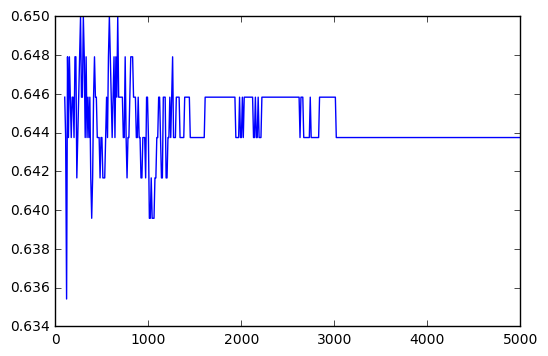

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
clf = RandomForestClassifier(n_estimators = 0, warm_start=True)
x_cr = range(100, 5000, 10)
y_cr = np.ndarray(len(x_cr))
it = 0
for i in range(100, 5000, 10):
    clf.set_params(n_estimators = i)
    clf.fit(X_train, y_train)
    y_cr[it] = accuracy_score(clf.predict(X_test), y_test)
    it += 1
    print(i)
plt.plot(x_cr, y_cr)
plt.show()

100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
2220
2230
2240
2250
2260
2270


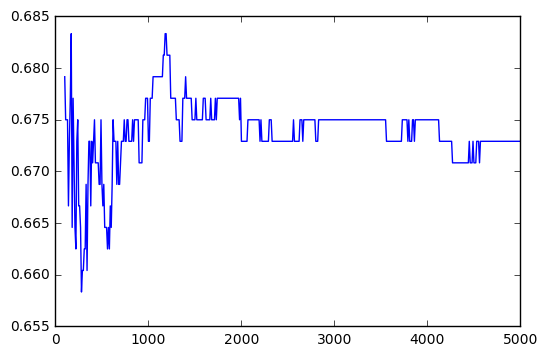

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
clf = BaggingClassifier(n_estimators = 0, warm_start=True, max_features = 0.5)
x_cr = range(100, 5000, 10)
y_cr = np.ndarray(len(x_cr))
it = 0
for i in range(100, 5000, 10):
    clf.set_params(n_estimators = i)
    clf.fit(X_train, y_train)
    y_cr[it] = accuracy_score(clf.predict(X_test), y_test)
    it += 1
    print(i)
plt.plot(x_cr, y_cr)
plt.show()

Лес не перобучается с увеличением числа деревьев.
<img src="image/random_forest.png">

BaggingClassifier не перобучается с увеличением n_estimators
<img src="image/BaggingClassifier.png">

Здесь вы можете поделиться мыслями о задании.

А здесь — вставить нарисованную вами смешную картинку.